<a href="https://colab.research.google.com/github/astrid12345/recyclo/blob/relabeler/scripts/relabeler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The purpose of this notebook is to convert the Aquatrash dataset to a format that can be used to train an Ultralytics YOLO model.

# Using this notebook: workflow

To use, make a copy of this notebook, and adapt it to work with your specific dataset. Please save your version of this ipynb file on GitHub in *recyclo/scripts*.

(File > Save a copy in GitHub > File path = "scripts/my_filename.ipynb" to save notebook in scripts folder)

Once you've generated your YOLO dataset, and are confident you can train a model with it, please upload your converted dataset to the Recyclo datasets google drive, https://drive.google.com/drive/folders/1bUkIYQRXX08OKI5TuOSg-eqntSudGaFB.

(Why Google Drive? Because these datasets are too large for GitHub!)

# What's in this notebook: contents

Notebook contents:
- intro to YOLO
- intro to AquaTrash
- dataset specific notes (update for your specific dataset)

# Pro tips about Colabs

When you open the "Files" tab on the left, you'll find yourself in a folder containing
* ..
* sample data

This is a colab thing, the "content" folder, to get you started.
Ignore it: click the .. to go up a level.

# Intro to YOLO

## General

In general, YOLO models output the following for a given image:
* Bounding box
* Class label
* Confidence score

To train a YOLO model, we need object detection datasets that contain images of what we're looking for (trash), and annotations: class labels and bounding boxes.

## Ultralytics YOLO

In this project we will use Ultralytics YOLO object detection, eg their YOLO11n model. YOLO11n is a pretrained object detection model developed by Ultralytics.

Ultralytics YOLO expects datasets in the following format:

```
dataset/
├── images/
│   ├── train/  <-- image files for training.
│   ├── val/    <-- image files for validation after each epoch. Must not overlap with images in train.
|   └── test/   <-- optional: can put some image files here for benchmarking.
├── labels/
│   ├── train/  <-- one .txt file per train image (must have same name). Contains class and bbox info..
│   ├── val/    <-- one .txt file per val image.
|   └── test/   <-- one .txt file per test image.
└── data.yaml   <-- config file; helps tie all the above together.
```

Example labels/train file:
```
<class_id> <x_center> <y_center> <width> <height>
```

Example data.yaml file:
```
path: /content/dataset  # Root folder
train: images/train
val: images/val

nc: 5  # number of classes
names: ['bottle', 'can', 'plastic bag', 'wrapper', 'paper']

```

# Intro to AquaTrash

## General

This dataset contains 369 images of Trash used for deep learning. Each image is manually labelled by our team for accurate detections making a total of 470 bounding boxes. There are total 4 classes {(0: glass), (1:paper), (2:metal), (3:plastic)}.

Each image stored in the images folder has one or more labelled bounding boxes.

The labelled bounding box are stored in the annotations.csv file with the following format:

```
<file_path>,<x_min>,<y_min>,<x_max>,<y_max>

```


---
⚠️‼️ ***THE SECTION TO CHANGE FOR YOUR SPECIFIC DATASET STARTS HERE*** ‼️⚠️

The sections above apply for all dataset conversions.

---

In [3]:
# ✏️ Enter your dataset-specific code here
# This cell is for importing your dataset to the notebook, and defining its name and path.

from pathlib import Path

dataset_name = "AquaTrash"
dataset_path = Path('/content/AquaTrash_dataset')
if not dataset_path.exists():
    print(f"Cloning AquaTrash dataset to {dataset_path}...")
    !git clone https://github.com/Harsh9524/AquaTrash.git /content/AquaTrash_dataset
    print(f"Dataset downloaded to {dataset_path}\n")
else:
    print(f"Dataset directory {dataset_path} already exists. Skipping clone.\n")

print(f"{dataset_name} dataset downloaded to {dataset_path}\n")

Cloning AquaTrash dataset to /content/AquaTrash_dataset...
Cloning into '/content/AquaTrash_dataset'...
remote: Enumerating objects: 2948, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 2948 (delta 22), reused 6 (delta 1), pack-reused 2902 (from 1)
Receiving objects: 100% (2948/2948), 122.45 MiB | 24.67 MiB/s, done.
Resolving deltas: 100% (22/22), done.
Dataset downloaded to /content/AquaTrash_dataset

AquaTrash dataset downloaded to /content/AquaTrash_dataset



# AquaTrash dataset
✏️ Modify this section for your specific dataset.

The AquaTrash dataset uses an unusual formatting. It has an annotations.json file that contains the labelling information in the format of

```
<image name> <x_min> <y_min> <x_max> <y_max> <class_name>
```

## Conversion
To convert the AquaTrash dataset to a format ultralytics YOLO can use, we must:
* Split the images into train, val, and test sets
* Extract label and bbox info from annotations.csv, convert it to

```
<class_id> <x_center> <y_center> <width> <height>
```
* Make a data.yaml file

In [4]:
import shutil
from pathlib import Path
import pandas as pd
from PIL import Image
dataset_name = "AquaTrash"
dataset_path = Path('/content/AquaTrash_dataset')
source_images_path = dataset_path / 'Images'
annotations_path = dataset_path / 'annotations.csv'
n_total = sum(1 for _ in source_images_path.glob('*.jpg'))  # a quick way to find out how many files are in the Images folder
# Set up output folder system
output_root = dataset_path.parent / f"{dataset_name}_yolo_{n_total}"
yolo_img_dirs = {
    'train': output_root / 'images' / 'train',
    'val': output_root / 'images' / 'val',
    'test': output_root / 'images' / 'test',
}
yolo_lbl_dirs = {
    'train': output_root / 'labels' / 'train',
    'val': output_root / 'labels' / 'val',
    'test': output_root / 'labels' / 'test',
}
# Clear and recreate folders if the script is run a 2nd time
for d in list(yolo_img_dirs.values()) + list(yolo_lbl_dirs.values()):
    if d.exists():
        shutil.rmtree(d)
    d.mkdir(parents=True, exist_ok=True)
# Load annotations
df = pd.read_csv(annotations_path)
default_class_id = 0              # We decided to only use one class, 'trash', so all labels will have a class ID of 0
grouped = df.groupby('image_name') # Group annotations by image, since one image often has multiple labels in the csv
grouped = list(df.groupby('image_name'))  # convert to list so shuffle works
# Compute dataset split
n_train = int(0.8 * len(grouped)) # 80% of the images to training
n_val = int(0.1 * len(grouped))   # 10% to val
n_test = len(grouped) - n_train - n_val  # the rest to test
splits = ['train'] * n_train + ['val'] * n_val + ['test'] * n_test
# Process each image
for i, ((file_path, group), split) in enumerate(zip(grouped, splits)):
    src_img_path = source_images_path / Path(file_path).name
    if not src_img_path.exists():
        print(f"Warning: {src_img_path} not found, skipping.")
        continue
    # Open image to get dimensions
    with Image.open(src_img_path) as img:
        width, height = img.size
    # Let's rename the file's while we're at it
    base_name = f"{dataset_name}_{i:06}"
    new_img_name = base_name + ".jpg"
    new_lbl_name = base_name + ".txt"
    # Copy image to destination YOLO folder (train, val, or test)
    shutil.copy(src_img_path, yolo_img_dirs[split] / new_img_name)
    # Convert label data to YOLO format, and write it to the corresponding label file
    label_lines = []
    for _, row in group.iterrows():
        x_min, y_min, x_max, y_max = row[['x_min', 'y_min', 'x_max', 'y_max']]
        x_center = ((x_min + x_max) / 2) / width
        y_center = ((y_min + y_max) / 2) / height
        box_width = (x_max - x_min) / width
        box_height = (y_max - y_min) / height
        label_lines.append(f"{default_class_id} {x_center:.6f} {y_center:.6f} {box_width:.6f} {box_height:.6f}")
    with open(yolo_lbl_dirs[split] / new_lbl_name, 'w') as f:
        f.write('\n'.join(label_lines))
# generate data.yaml
data_yaml_path = output_root / 'data.yaml'
with open(data_yaml_path, 'w') as f:
    f.write("names: ['trash']\n")
    f.write("nc: 1\n")
    f.write(f"path: {output_root}\n")
    f.write("train: images/train\n")
    f.write("val: images/val\n")
    f.write("test: images/test\n")
print(f"Converted {len(grouped)} images to YOLO format with 80/10/10 train/val/test split at: {output_root}")

Converted 369 images to YOLO format with 80/10/10 train/val/test split at: /content/AquaTrash_yolo_369


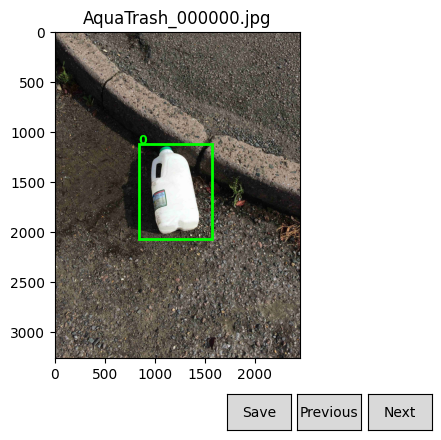

In [6]:
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.widgets import Button
from pathlib import Path
import numpy as np

# Set your output root Path object
split = 'train'  # or 'val', 'test'

image_dir = output_root / 'images' / split
label_dir = output_root / 'labels' / split
label_dir.mkdir(parents=True, exist_ok=True)

image_files = sorted([f for f in image_dir.iterdir() if f.suffix.lower() in ['.jpg', '.jpeg', '.png']])
current_index = 0
boxes = []
class_ids = []

fig, ax = plt.subplots()
plt.subplots_adjust(bottom=0.2)
rect_patch = None
start_point = None
img = None
img_disp = None
image_file = ""

def load_image(index):
    global img, img_disp, boxes, class_ids, image_file
    image_file = image_files[index]
    label_file = label_dir / f"{image_file.stem}.txt"

    img = cv2.imread(str(image_file))
    img_disp = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]

    boxes = []
    class_ids = []

    if label_file.exists():
        with label_file.open('r') as f:
            for line in f:
                class_id, x_c, y_c, bw, bh = map(float, line.strip().split())
                x = int((x_c - bw / 2) * w)
                y = int((y_c - bh / 2) * h)
                bw_px = int(bw * w)
                bh_px = int(bh * h)
                boxes.append([x, y, bw_px, bh_px])
                class_ids.append(int(class_id))

def draw_image():
    ax.clear()
    ax.imshow(img_disp)
    for i, (x, y, bw, bh) in enumerate(boxes):
        rect = Rectangle((x, y), bw, bh, linewidth=2, edgecolor='lime', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y - 5, str(class_ids[i]), color='lime', fontsize=9, weight='bold')
    ax.set_title(image_file.name)
    fig.canvas.draw()

def on_press(event):
    global start_point, rect_patch
    if event.inaxes != ax: return
    start_point = (int(event.xdata), int(event.ydata))
    rect_patch = Rectangle(start_point, 0, 0, linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect_patch)

def on_motion(event):
    if start_point is None or event.inaxes != ax: return
    x0, y0 = start_point
    x1, y1 = int(event.xdata), int(event.ydata)
    rect_patch.set_width(x1 - x0)
    rect_patch.set_height(y1 - y0)
    rect_patch.set_xy((x0, y0))
    fig.canvas.draw()

def on_release(event):
    global start_point
    if start_point is None or event.inaxes != ax: return
    x0, y0 = start_point
    x1, y1 = int(event.xdata), int(event.ydata)
    x, y = min(x0, x1), min(y0, y1)
    w, h = abs(x1 - x0), abs(y1 - y0)
    if w > 0 and h > 0:
        boxes.append([x, y, w, h])
        class_ids.append(0)  # default class ID
    start_point = None
    draw_image()

def save_labels(event=None):
    label_file = label_dir / f"{image_file.stem}.txt"
    h_img, w_img = img.shape[:2]
    with label_file.open('w') as f:
        for cls, (x, y, bw, bh) in zip(class_ids, boxes):
            x_center = (x + bw / 2) / w_img
            y_center = (y + bh / 2) / h_img
            bw_norm = bw / w_img
            bh_norm = bh / h_img
            f.write(f"{cls} {x_center:.6f} {y_center:.6f} {bw_norm:.6f} {bh_norm:.6f}\n")
    print(f"Saved: {label_file}")

def next_image(event=None):
    global current_index
    save_labels()
    if current_index < len(image_files) - 1:
        current_index += 1
        load_image(current_index)
        draw_image()

def prev_image(event=None):
    global current_index
    save_labels()
    if current_index > 0:
        current_index -= 1
        load_image(current_index)
        draw_image()

# Buttons
btn_ax_next = plt.axes([0.81, 0.05, 0.1, 0.075])
btn_ax_prev = plt.axes([0.7, 0.05, 0.1, 0.075])
btn_ax_save = plt.axes([0.59, 0.05, 0.1, 0.075])

btn_next = Button(btn_ax_next, 'Next')
btn_prev = Button(btn_ax_prev, 'Previous')
btn_save = Button(btn_ax_save, 'Save')

btn_next.on_clicked(next_image)
btn_prev.on_clicked(prev_image)
btn_save.on_clicked(save_labels)

# Bind mouse
fig.canvas.mpl_connect('button_press_event', on_press)
fig.canvas.mpl_connect('motion_notify_event', on_motion)
fig.canvas.mpl_connect('button_release_event', on_release)

# Initial load
load_image(current_index)
draw_image()
plt.show()


---
⚠️‼️ ***THE SECTION TO CHANGE FOR YOUR SPECIFIC DATASET STOPS HERE*** ‼️⚠️

The sections below apply for all dataset conversions.

---

To verify that your conversion worked, make sure you can train a model and that it outputs images with a bounding box and label.

In [3]:
# ⚠️ DO NOT MODIFY THIS CELL
# This cell imports the ultralytics library required for training a model

!pip install -U ultralytics

from ultralytics import YOLO
import os

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 65.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [12]:
# ⚠️ DO NOT MODIFY THIS CELL
# This cell trains a YOLO model on the converted YOLO dataset to see if it's set up correctly
# Tip: inspect the output of this cell to assess whether training occured properly.

model = YOLO('yolo11n.pt')
# Use the output_root directly as the data path
results = model.train(data=str(output_root / 'data.yaml'), epochs=6, imgsz=640)  # epoch size is small - this is just to see if it can work!

Ultralytics 8.3.155 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/AquaTrash_yolo_369/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=6, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, p

train: Scanning /content/AquaTrash_yolo_369/labels/train.cache... 295 images, 0 backgrounds, 0 corrupt: 100%|██████████| 295/295 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 478.2±228.8 MB/s, size: 210.8 KB)


val: Scanning /content/AquaTrash_yolo_369/labels/val.cache... 36 images, 0 backgrounds, 0 corrupt: 100%|██████████| 36/36 [00:00<?, ?it/s]


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train3
Starting training for 6 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/6      2.32G      1.796      3.366      1.622         17        640: 100%|██████████| 19/19 [00:08<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.36it/s]

                   all         36         43     0.0038      0.953       0.53      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/6      2.71G      1.791      2.636      1.553         16        640: 100%|██████████| 19/19 [00:05<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.93it/s]

                   all         36         43      0.914      0.246      0.586      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/6      2.72G      1.856      2.622      1.659         10        640: 100%|██████████| 19/19 [00:07<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.34it/s]

                   all         36         43      0.865      0.299      0.466       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/6      2.72G      1.742       2.37      1.618         16        640: 100%|██████████| 19/19 [00:06<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.86it/s]

                   all         36         43      0.586      0.263      0.327       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/6      2.72G      1.776      2.276      1.598         14        640: 100%|██████████| 19/19 [00:06<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.25it/s]

                   all         36         43      0.544      0.442      0.525      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        6/6      2.72G      1.682      2.141      1.529         15        640: 100%|██████████| 19/19 [00:06<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.06it/s]

                   all         36         43      0.764      0.558      0.641      0.307



6 epochs completed in 0.014 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 5.5MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics 8.3.155 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.10it/s]


                   all         36         43      0.763      0.558      0.641      0.307
Speed: 0.3ms preprocess, 4.2ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/train3


If the model outputs even one image with a bounding box and label, then the dataset should work for our project! Verify this using the code below.

Loading runs/detect/train3/weights/best.pt

image 1/1 /content/AquaTrash_yolo_369/images/train/AquaTrash_000276.jpg: 640x640 1 trash, 8.3ms
Speed: 2.6ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


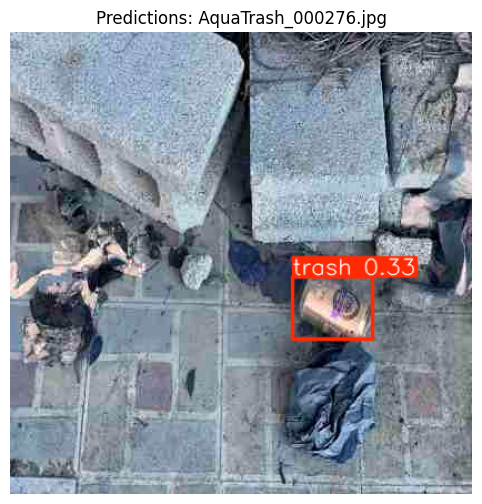


image 1/1 /content/AquaTrash_yolo_369/images/train/AquaTrash_000107.jpg: 640x640 (no detections), 14.7ms
Speed: 4.1ms preprocess, 14.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


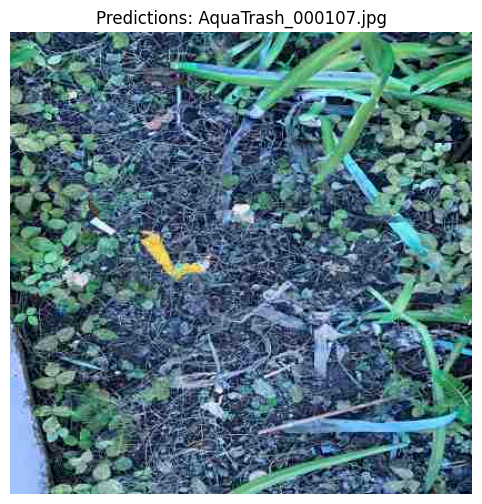


image 1/1 /content/AquaTrash_yolo_369/images/train/AquaTrash_000000.jpg: 640x480 1 trash, 12.3ms
Speed: 4.5ms preprocess, 12.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)


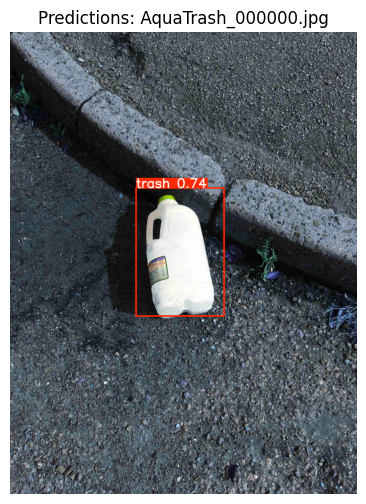


image 1/1 /content/AquaTrash_yolo_369/images/train/AquaTrash_000016.jpg: 416x640 (no detections), 16.6ms
Speed: 5.8ms preprocess, 16.6ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


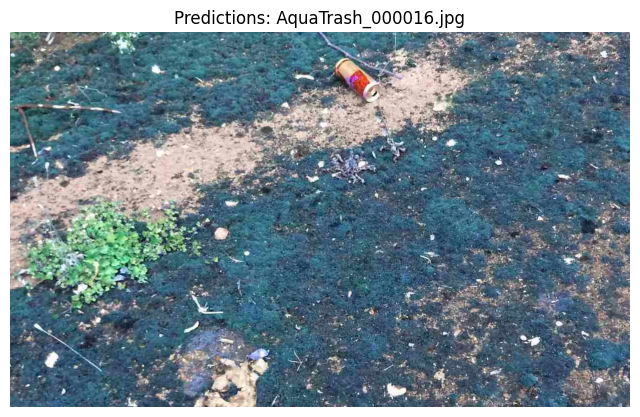


image 1/1 /content/AquaTrash_yolo_369/images/train/AquaTrash_000046.jpg: 640x480 1 trash, 15.7ms
Speed: 4.1ms preprocess, 15.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 480)


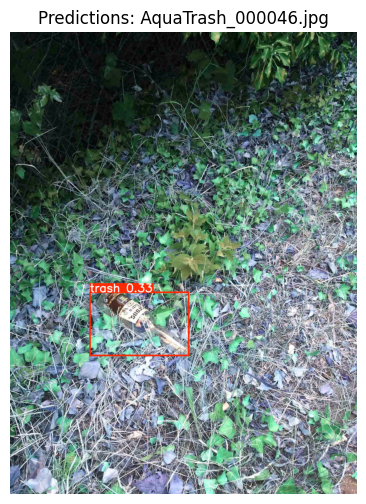


image 1/1 /content/AquaTrash_yolo_369/images/train/AquaTrash_000042.jpg: 640x640 2 trashs, 17.3ms
Speed: 4.1ms preprocess, 17.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


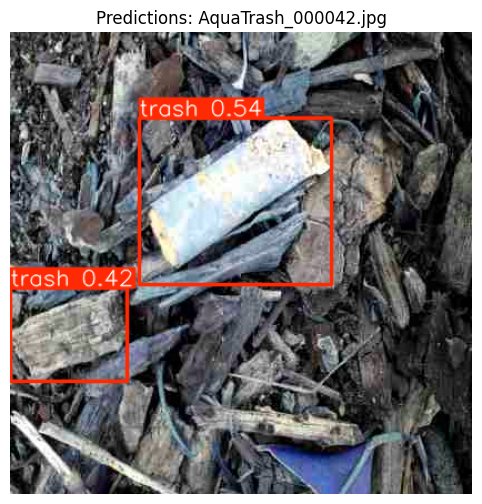


image 1/1 /content/AquaTrash_yolo_369/images/train/AquaTrash_000064.jpg: 640x480 2 trashs, 13.8ms
Speed: 4.6ms preprocess, 13.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)


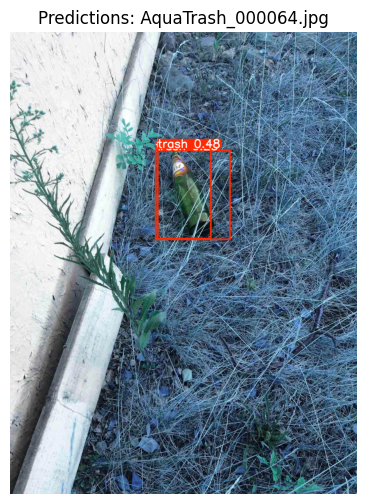


image 1/1 /content/AquaTrash_yolo_369/images/train/AquaTrash_000102.jpg: 640x640 1 trash, 14.4ms
Speed: 4.0ms preprocess, 14.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


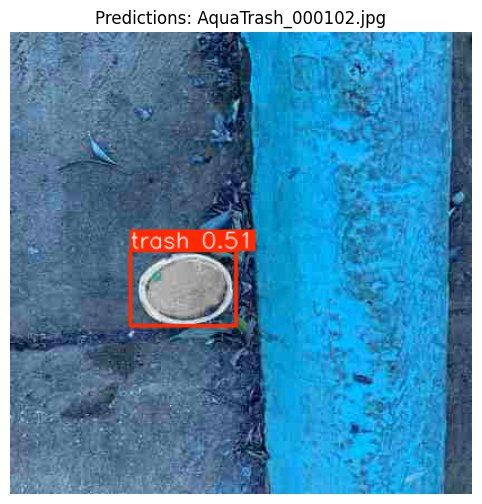


image 1/1 /content/AquaTrash_yolo_369/images/train/AquaTrash_000160.jpg: 640x640 1 trash, 13.6ms
Speed: 4.1ms preprocess, 13.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


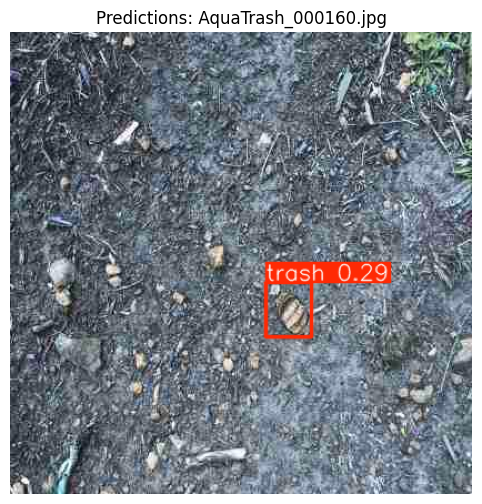


image 1/1 /content/AquaTrash_yolo_369/images/train/AquaTrash_000194.jpg: 640x480 1 trash, 12.9ms
Speed: 4.9ms preprocess, 12.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)


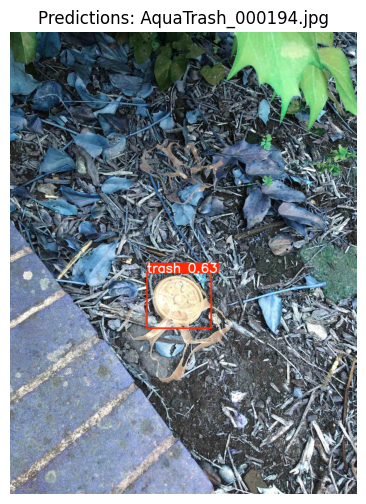

In [14]:
# ⚠️ DO NOT MODIFY THIS CELL
# This cell passes the trained model some images, to see if the model can identify some trash

import cv2
from random import sample
import matplotlib.pyplot as plt
import os # Moved import here

# Get the latest model
runs_detect_dir = Path('runs/detect')
train_dirs = [d for d in runs_detect_dir.iterdir() if d.is_dir() and d.name.startswith("train")]
train_dirs.sort(key=lambda d: d.stat().st_mtime, reverse=True)  # sort by modification time
latest_train_dir = train_dirs[0]
best_model_path = latest_train_dir / 'weights' / 'best.pt'
print(f"Loading {best_model_path}")

# Load the model and try it out
model = YOLO(best_model_path)
train_images_path = output_root / "images" / "train" # Corrected path to use output_root
image_files = list(train_images_path.glob('*.jpg'))

sample_images = sample(image_files, 10)

for image_path in sample_images:
    result = model(image_path)[0]
    annotated_image = result.plot()

    plt.figure(figsize=(8, 6))
    plt.imshow(annotated_image)
    plt.title(f'Predictions: {image_path.name}')
    plt.axis('off')
    plt.show()

If the model successfully generated even one image with a bounding box and label, please run the following code block to zip the yolo dataset, download the zipped file, and upload it on Google Drive, https://www.google.com/url?q=https%3A%2F%2Fdrive.google.com%2Fdrive%2Ffolders%2F1bUkIYQRXX08OKI5TuOSg-eqntSudGaFB.

In [17]:
# ⚠️ DO NOT MODIFY THIS CELL
# This cell zips your converted YOLO dataset with an informative name, so you can download it and upload it to google drive.

from datetime import datetime
from pathlib import Path
import os

# Generate date prefix
date_str = datetime.now().strftime('%Y%m%d')

# Define the folder to zip (the final YOLO dataset folder)
folder_to_zip = output_root # output_root is set to the path of the generated YOLO dataset

# Define the name of the output zip file
# Using the parent directory name in the zip name might be confusing if the folder to zip is the final output
# Let's use the folder_to_zip name directly for the zip name prefix
zip_name = f"{date_str}_{folder_to_zip.name}.zip"

# Define the full path for the output zip file
output_zip_path = Path('/content') / zip_name

# Change directory to the parent of the folder to zip so the zip command includes the folder itself
# Or, more simply, use the zip command directly on the folder_to_zip path
# %cd {folder_to_zip.parent} # No need to change directory if zipping directly

print(f"Creating zip archive from {folder_to_zip}...")

# Use the zip command to archive the specific folder
# The -r flag is for recursive zipping (includes subdirectories)
# The first argument is the output zip file path
# The second argument is the folder to be zipped (relative to the current directory or absolute path)
# We will use the absolute path to the folder_to_zip
!cd {folder_to_zip} && zip -r {output_zip_path} *

print(f"Zip created at {output_zip_path}")

Creating zip archive from /content/AquaTrash_yolo_369...
  adding: data.yaml (deflated 20%)
  adding: images/ (stored 0%)
  adding: images/test/ (stored 0%)
  adding: images/test/AquaTrash_000364.jpg (deflated 0%)
  adding: images/test/AquaTrash_000368.jpg (deflated 3%)
  adding: images/test/AquaTrash_000367.jpg (deflated 2%)
  adding: images/test/AquaTrash_000349.jpg (deflated 5%)
  adding: images/test/AquaTrash_000350.jpg (deflated 4%)
  adding: images/test/AquaTrash_000335.jpg (deflated 0%)
  adding: images/test/AquaTrash_000338.jpg (deflated 0%)
  adding: images/test/AquaTrash_000348.jpg (deflated 0%)
  adding: images/test/AquaTrash_000333.jpg (deflated 0%)
  adding: images/test/AquaTrash_000358.jpg (deflated 0%)
  adding: images/test/AquaTrash_000354.jpg (deflated 8%)
  adding: images/test/AquaTrash_000357.jpg (deflated 0%)
  adding: images/test/AquaTrash_000360.jpg (deflated 1%)
  adding: images/test/AquaTrash_000346.jpg (deflated 0%)
  adding: images/test/AquaTrash_000336.jpg (d